# XGBOOST Cleaning

## Import

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import os 
import sklearn as sklearn
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split, learning_curve, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt


## Change directory 


In [2]:
os.chdir('/Users/bryanburzon/School/DS207/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/bryan_playground')

## Load Data

In [3]:
# Test 
test_df = pd.read_csv('/Users/bryanburzon/School/DS207/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/bryan_playground/xgboost/data/test_df.csv')

# Train
train_df = pd.read_csv('/Users/bryanburzon/School/DS207/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/bryan_playground/xgboost/data/train_df.csv')

### Combine Data

In [4]:
df = pd.concat([test_df, train_df])

In [5]:
df.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'EJ_A', 'EJ_B',
       'Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon', 'EpochTime'],
      dtype='object')

In [6]:
class_0 = df[df['Class']== 0].sample(n=108, random_state=42)
class_1 = df[df['Class']== 1]
df = pd.concat([class_0, class_1])

### Filter Column to just PCA columns

In [7]:
columns = ['DU', 'AB', 'BQ', 'GL', 'CR', 'DA', 'DI', 'AF', 'CC', 'EE', 'FR', 'DE', 'EB', 'DL', 'CD ', 'FE', 'DH', 'BC', 'FI', 'EU', 'BN', 'BP', 'CU', 'CB', 'DY', 'FC', 'DN', 'AM', 'EG', 'CS', 'GH', 'CF', 'GF', 'BD ', 'GI']
x = df[columns].copy()
y = df['Class'].copy()

### Down Sample Larger Class

In [8]:
len(df)

216

In [9]:
len(df[df['Class']== 1])

108

### Split Data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state = 42, stratify = y)

In [11]:
y_train.unique()

array([1, 0])

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,test_size=0.333, random_state = 42, stratify = y_train)

In [13]:
y_train.unique()

array([1, 0])

### Write to CSV

In [14]:
file_path = '/Users/bryanburzon/School/DS207/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/bryan_playground/xgboost/cluster_data/x_train_cluster_samp.csv'
x_train.to_csv(file_path, index=False)

file_path = '/Users/bryanburzon/School/DS207/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/bryan_playground/xgboost/cluster_data/x_test_cluster_samp.csv'
x_test.to_csv(file_path, index=False)

file_path = '/Users/bryanburzon/School/DS207/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/bryan_playground/xgboost/cluster_data/y_train_cluster_samp.csv'
y_train.to_csv(file_path, index=False)

file_path = '/Users/bryanburzon/School/DS207/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/bryan_playground/xgboost/cluster_data/y_test_cluster_samp.csv'
y_test.to_csv(file_path, index=False)

### One Hot Encoding

No one hot encoding as all colums are numeric types

### Custom Eval Metric

In [15]:
def balanced_log_loss(y_true, y_pred):
    N0 = np.sum(y_true == 0) #num observations class 0
    N1 = np.sum(y_true == 1) #num observations class 1

    p0 = y_pred[y_true == 0] #pred_prob class 0
    p1 = y_pred[y_true == 1] #pred_prob class 0

    y0 = y_true[y_true == 0] #ground truth class 0
    y1 = y_true[y_true == 1] #ground truth class 1

    log_loss_0 = np.sum(y0 * np.log(np.clip(p0, 1e-15, 1.0))) / N0 if N0 > 0 else 0 #balanced log loss class 0, adjust for edge cases (removed the negative sign to avoid negative log loss)
    log_loss_1 = np.sum(y1 * np.log(np.clip(p1, 1e-15, 1.0))) / N1 if N1 > 0 else 0 #balanced log loss class 1, adjust for edge cases 

    return (log_loss_0 + log_loss_1) / 2

## Build Model 

In [16]:
# xgb1 = xgb.XGBClassifier(objective = 'binary:logistic', 
#                         learning_rate = .1,
#                         max_depth =  3,
#                         missing = np.nan, 
#                         # n_estimators= 100,
#                         epoch = 4,
#                         seed= 42, 
#                         verbosity = 1,
#                         early_stopping_rounds=100,
#                         eval_metric=['logloss','auc'])

xgb1 = xgb.XGBClassifier(
                        eval_metric=['logloss','auc'])


xgb1.fit(x_train,y_train, eval_set=[(x_train, y_train),(x_valid, y_valid)], verbose = True)


[0]	validation_0-logloss:0.51028	validation_0-auc:0.97122	validation_1-logloss:0.57700	validation_1-auc:0.80916
[1]	validation_0-logloss:0.40262	validation_0-auc:0.99200	validation_1-logloss:0.50990	validation_1-auc:0.85612
[2]	validation_0-logloss:0.32141	validation_0-auc:0.99800	validation_1-logloss:0.43226	validation_1-auc:0.93044
[3]	validation_0-logloss:0.26417	validation_0-auc:0.99908	validation_1-logloss:0.40938	validation_1-auc:0.91795
[4]	validation_0-logloss:0.21773	validation_0-auc:1.00000	validation_1-logloss:0.37417	validation_1-auc:0.93757
[5]	validation_0-logloss:0.18580	validation_0-auc:1.00000	validation_1-logloss:0.35769	validation_1-auc:0.93698
[6]	validation_0-logloss:0.15995	validation_0-auc:1.00000	validation_1-logloss:0.35934	validation_1-auc:0.93341
[7]	validation_0-logloss:0.13963	validation_0-auc:1.00000	validation_1-logloss:0.33363	validation_1-auc:0.94174
[8]	validation_0-logloss:0.12332	validation_0-auc:1.00000	validation_1-logloss:0.32053	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

### Evaluate model

Test Set Accuracy: 0.841
Test Set Balanced Log Loss: -3.1399


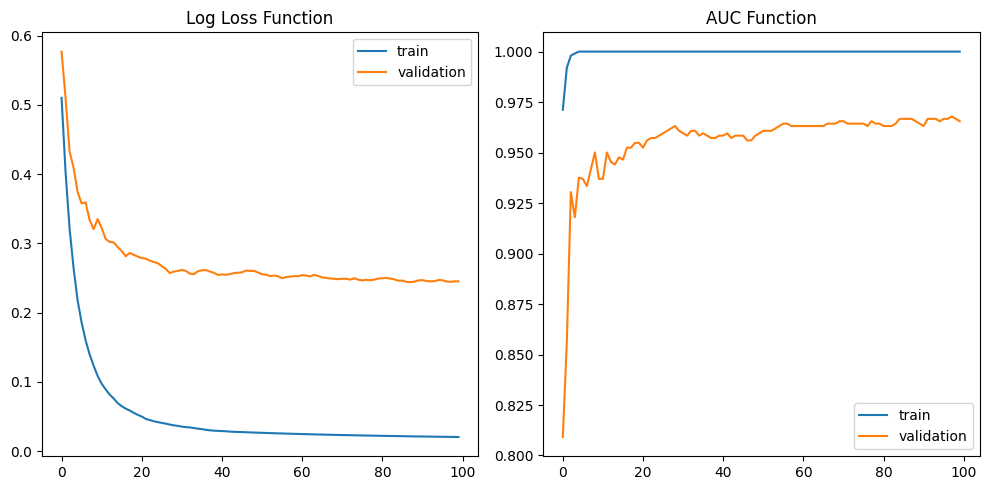

In [17]:
yhat = xgb1.predict(x_test)
score = accuracy_score(y_test, yhat)
print('Test Set Accuracy: %.3f' % score)
print('Test Set Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test, yhat)))

# retrieve performance metrics
results = xgb1.evals_result()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot learning curves
axs[0].plot(results['validation_0']['logloss'], label='train')
axs[0].plot(results['validation_1']['logloss'], label='validation')
axs[0].set_title('Log Loss Function')
axs[0].legend()
# show the plot
# axs[0].plt.show()

# plot learning curves
axs[1].plot(results['validation_0']['auc'], label='train')
axs[1].plot(results['validation_1']['auc'], label='validation')
axs[1].set_title('AUC Function')
axs[1].legend()
# show the plot
plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()  # Display the plots

## 2 Try 

[0]	validation_0-logloss:0.51028	validation_0-auc:0.97122	validation_1-logloss:0.57700	validation_1-auc:0.80916
[1]	validation_0-logloss:0.40262	validation_0-auc:0.99200	validation_1-logloss:0.50990	validation_1-auc:0.85612
[2]	validation_0-logloss:0.32141	validation_0-auc:0.99800	validation_1-logloss:0.43226	validation_1-auc:0.93044
[3]	validation_0-logloss:0.26417	validation_0-auc:0.99908	validation_1-logloss:0.40938	validation_1-auc:0.91795
[4]	validation_0-logloss:0.21773	validation_0-auc:1.00000	validation_1-logloss:0.37417	validation_1-auc:0.93757
[5]	validation_0-logloss:0.18580	validation_0-auc:1.00000	validation_1-logloss:0.35769	validation_1-auc:0.93698
[6]	validation_0-logloss:0.15995	validation_0-auc:1.00000	validation_1-logloss:0.35934	validation_1-auc:0.93341
[7]	validation_0-logloss:0.13963	validation_0-auc:1.00000	validation_1-logloss:0.33363	validation_1-auc:0.94174
[8]	validation_0-logloss:0.12332	validation_0-auc:1.00000	validation_1-logloss:0.32053	validation_1-auc:

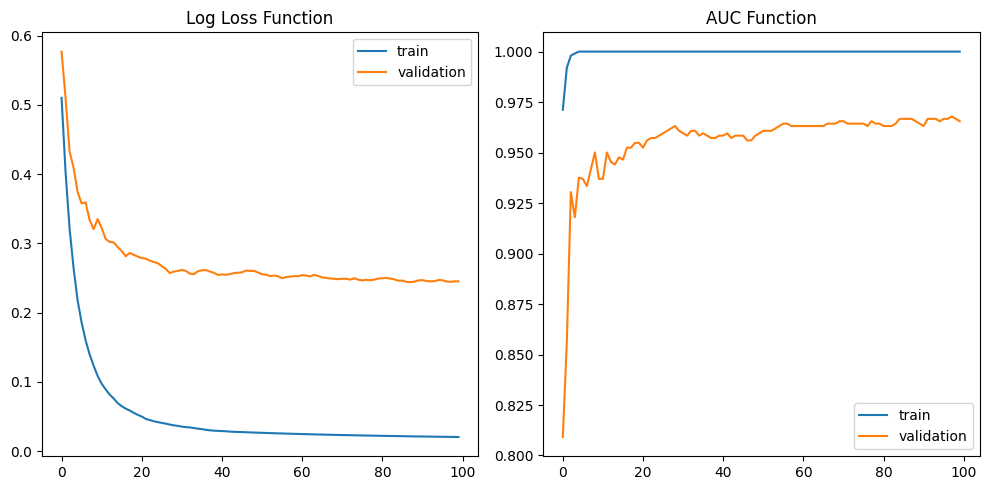

In [18]:
xgb1 = xgb.XGBClassifier(objective = 'binary:logistic', 
                        eval_metric=['logloss','auc'])



xgb1.fit(x_train,y_train, eval_set=[(x_train, y_train),(x_valid, y_valid)])

yhat = xgb1.predict(x_test)
score = accuracy_score(y_test, yhat)
print('Test Set Accuracy: %.3f' % score)
print('Test Set Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test, yhat)))

# retrieve performance metrics
results = xgb1.evals_result()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot learning curves
axs[0].plot(results['validation_0']['logloss'], label='train')
axs[0].plot(results['validation_1']['logloss'], label='validation')
axs[0].set_title('Log Loss Function')
axs[0].legend()
# show the plot
# axs[0].plt.show()

# plot learning curves
axs[1].plot(results['validation_0']['auc'], label='train')
axs[1].plot(results['validation_1']['auc'], label='validation')
axs[1].set_title('AUC Function')
axs[1].legend()
# show the plot
plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()  # Display the plots


# 3rd Try 

[0]	validation_0-logloss:0.56583	validation_0-auc:0.88704	validation_1-logloss:0.60853	validation_1-auc:0.76873
[1]	validation_0-logloss:0.48195	validation_0-auc:0.95152	validation_1-logloss:0.52720	validation_1-auc:0.87515
[2]	validation_0-logloss:0.42271	validation_0-auc:0.96753	validation_1-logloss:0.49597	validation_1-auc:0.88942
[3]	validation_0-logloss:0.36639	validation_0-auc:0.98092	validation_1-logloss:0.44007	validation_1-auc:0.90666
[4]	validation_0-logloss:0.32033	validation_0-auc:0.99015	validation_1-logloss:0.41810	validation_1-auc:0.90785
[5]	validation_0-logloss:0.29104	validation_0-auc:0.99077	validation_1-logloss:0.38520	validation_1-auc:0.92271
[6]	validation_0-logloss:0.26389	validation_0-auc:0.99231	validation_1-logloss:0.35755	validation_1-auc:0.93460
[7]	validation_0-logloss:0.23722	validation_0-auc:0.99508	validation_1-logloss:0.33602	validation_1-auc:0.94887
[8]	validation_0-logloss:0.21841	validation_0-auc:0.99661	validation_1-logloss:0.32340	validation_1-auc:

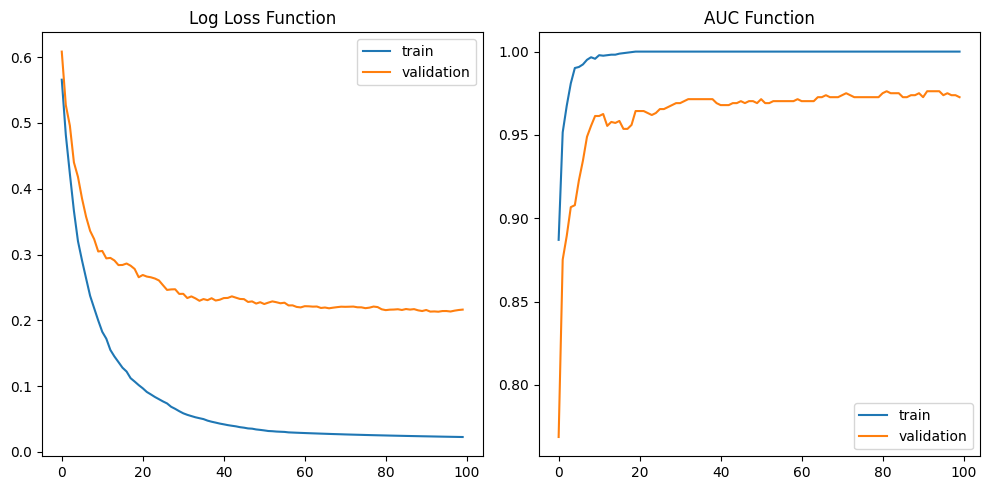

In [19]:
xgb1 = xgb.XGBClassifier(objective = 'binary:logistic', 
                        max_depth =  2,
                        eval_metric=['logloss','auc'])



xgb1.fit(x_train,y_train, eval_set=[(x_train, y_train),(x_valid, y_valid)])

yhat = xgb1.predict(x_test)
score = accuracy_score(y_test, yhat)
print('Test Set Accuracy: %.3f' % score)
print('Test Set Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test, yhat)))

# retrieve performance metrics
results = xgb1.evals_result()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot learning curves
axs[0].plot(results['validation_0']['logloss'], label='train')
axs[0].plot(results['validation_1']['logloss'], label='validation')
axs[0].set_title('Log Loss Function')
axs[0].legend()
# show the plot
# axs[0].plt.show()

# plot learning curves
axs[1].plot(results['validation_0']['auc'], label='train')
axs[1].plot(results['validation_1']['auc'], label='validation')
axs[1].set_title('AUC Function')
axs[1].legend()
# show the plot
plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()  # Display the plots

## 4th 

[0]	validation_0-logloss:0.65079	validation_0-auc:0.88704	validation_1-logloss:0.66342	validation_1-auc:0.76873
[1]	validation_0-logloss:0.61408	validation_0-auc:0.93737	validation_1-logloss:0.63826	validation_1-auc:0.79370
[2]	validation_0-logloss:0.58187	validation_0-auc:0.95429	validation_1-logloss:0.61473	validation_1-auc:0.82402
[3]	validation_0-logloss:0.55373	validation_0-auc:0.96768	validation_1-logloss:0.58690	validation_1-auc:0.87218
[4]	validation_0-logloss:0.52877	validation_0-auc:0.97153	validation_1-logloss:0.56999	validation_1-auc:0.88347
[5]	validation_0-logloss:0.50593	validation_0-auc:0.96999	validation_1-logloss:0.54832	validation_1-auc:0.89061
[6]	validation_0-logloss:0.48570	validation_0-auc:0.97276	validation_1-logloss:0.53576	validation_1-auc:0.89298
[7]	validation_0-logloss:0.46633	validation_0-auc:0.98076	validation_1-logloss:0.51334	validation_1-auc:0.90488
[8]	validation_0-logloss:0.44913	validation_0-auc:0.98076	validation_1-logloss:0.50253	validation_1-auc:

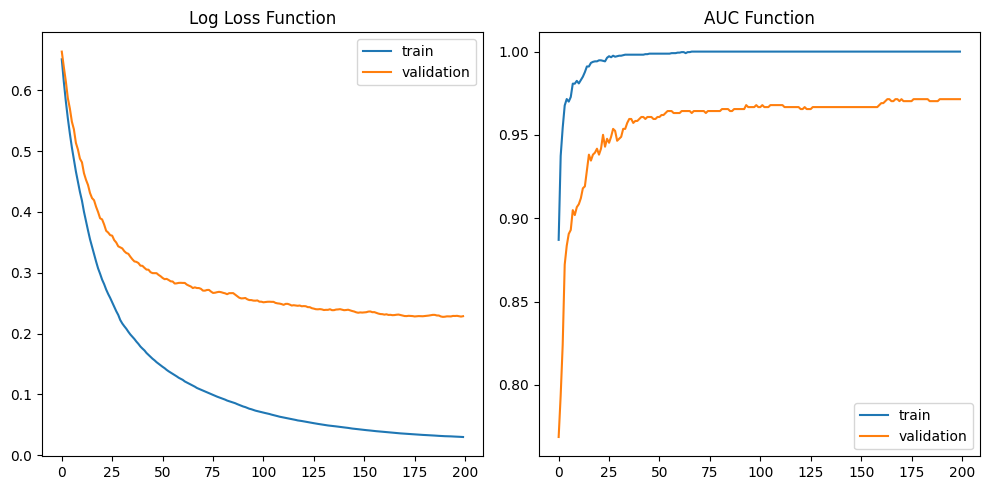

In [20]:
xgb1 = xgb.XGBClassifier(objective = 'binary:logistic', 
                        max_depth =  2,
                        eta = .09,
                        n_estimators=  200,
                        eval_metric=['logloss','auc'])



xgb1.fit(x_train,y_train, eval_set=[(x_train, y_train),(x_valid, y_valid)])

yhat = xgb1.predict(x_test)
score = accuracy_score(y_test, yhat)
print('Test Set Accuracy: %.3f' % score)
print('Test Set Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test, yhat)))

# retrieve performance metrics
results = xgb1.evals_result()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot learning curves
axs[0].plot(results['validation_0']['logloss'], label='train')
axs[0].plot(results['validation_1']['logloss'], label='validation')
axs[0].set_title('Log Loss Function')
axs[0].legend()
# show the plot
# axs[0].plt.show()

# plot learning curves
axs[1].plot(results['validation_0']['auc'], label='train')
axs[1].plot(results['validation_1']['auc'], label='validation')
axs[1].set_title('AUC Function')
axs[1].legend()
# show the plot
plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()  # Display the plots